### Exploring Belief State Geometry:

Source: [Transformers Represent Belief State Geometry in their Residual Stream](https://www.lesswrong.com/posts/gTZ2SxesbHckJ3CkF/transformers-represent-belief-state-geometry-in-their)

Note: All of the following writing is from me trying to grasp the subject while reading about it! Corrections appreciated. : )

Core ideas:
- We use computational mechanics as a framework to reason about the states of MDPs that are only partially observable to us.
- In an Hidden Markov Model (HMM), the data generation process is uniquely defined by the state transition probabilities $(S \rightarrow S)$ and the observation emission probabilities $(S \rightarrow O)$.
    - The sequence generated thus far is a "noisy" signal of the state trajectory.
- Let's imagine that we're observing a sequence of observations emitted by an HMM. We're unable to see the data observation process, but we can create a Markov Model of the *Belief State Process*.

<img src="https://res.cloudinary.com/lesswrong-2-0/image/upload/f_auto,q_auto/v1/mirroredImages/gTZ2SxesbHckJ3CkF/glq0uoshzsrmm8a2o1vu" alt="drawing" width="500"/>

Above, each node in the graph on the right is a belief state. (Very tentative) Each belief state represents a history of observations that uniquely defines the future observation sequence likelihood. That is to say, if two histories lead to a state that we observe will yield the same future observation trajectory distributions, we can represent the two histories with the same belief state. We call the above a mixed state presentation because each belief state defines an implicit distribution over the generator HMM's states.

We can map this graph on a simplex. An interesting side-effect of having recurrent generating structures is that they lead to fractal geometries in the MSP:

<img src="https://res.cloudinary.com/lesswrong-2-0/image/upload/f_auto,q_auto/v1/mirroredImages/gTZ2SxesbHckJ3CkF/xppfd3veqbcmfvkjyimr" alt="drawing" width="500"/>

The second remarkable finding is that transformers trained on sequences generated by toy MDPs linearly represent the corresponding MSPs
within their residual streams. Let's try to replicate these findings.

### Finding #1: Calculating MSPs

Let's define our generator process.

In [1]:
import collections, random

class HiddenMarkovProcess:
    def __init__(self, states: list, transition_matrix: dict,
                 observation_matrix: dict):
        self.states = states
        self.transition_matrix = transition_matrix
        self.observation_matrix = observation_matrix
        self.current_state = None

    def next_state(self, current_state):
        next_probs = self.transition_matrix[current_state]
        next_state = random.choices(self.states, weights = next_probs, k = 1)[0]
        return next_state

    def reset(self, start_state = None):
        if start_state is None:
            self.current_state = random.choice(self.states)
        else:
            self.current_state = start_state

    def step(self):
        observation_probs = self.observation_matrix[self.current_state] # dict of observation probabilities
        observation = random.choices(list(observation_probs.keys()), weights = list(observation_probs.values()), k = 1)[0]
        self.current_state = self.next_state(self.current_state)
        return observation, self.current_state
    
    def __repr__(self):
        return f"Current state: {self.current_state}"

In [2]:
# Simple toy example

coinflip = HiddenMarkovProcess(states = ['H', 'T'], 
                                transition_matrix = {'H': [0.5, 0.5], 'T': [0.5, 0.5]},
                                observation_matrix = {'H': {'H': 1, 'T': 0}, 'T': {'H': 0, 'T': 1}})
coinflip.reset()
for i in range(10):
    obs, new_s = coinflip.step()
    print(obs)

T
T
T
H
T
H
T
H
H
T


Looking at the graph, we have a 70% chance of remaining in each state and a 15% chance of transitioning to either of the other two states. Observation probabilities are noisy.

In [3]:
print(42 + 9*2, 14 + 6, 14+6)

60 20 20


In [4]:
mess3 = HiddenMarkovProcess(states = ['H0', 'H1', 'H2'],
                            transition_matrix = {'H0': [0.7, 0.15, 0.15], 
                                                 'H1': [0.15, 0.7, 0.15], 
                                                 'H2': [0.15, 0.15, 0.7]},
                            observation_matrix = {'H0': {'A': 0.6, 'B': 0.2, 'C': 0.2},
                                                  'H1': {'A': 0.2, 'B': 0.6, 'C': 0.2},
                                                  'H2': {'A': 0.2, 'B': 0.2, 'C': 0.6}})

mess3.reset()
for i in range(10):
    old_s = mess3.current_state
    obs, new_s = mess3.step()
    print(old_s, obs)

H0 A
H0 A
H2 B
H1 A
H2 B
H1 C
H1 B
H1 B
H1 B
H1 B


In [5]:
class DiscreteDistribution:
    def __init__(self, states: list, probabilities: list):
        self.states = states
        self.distribution = dict(zip(states, probabilities))
    def __iter__(self):
        return iter(self.distribution)
    def normalize(self):
        total = sum(self.distribution.values())
        for state in self.states:
            self.distribution[state] /= total
    def __repr__(self):
        return str({k: round(v, 3) for k, v in self.distribution.items()})
    def get_probs(self):
        return list(self.distribution.values())

# P(S_0)
p_s0 = DiscreteDistribution(states = ['H0', 'H1', 'H2'], probabilities = [1/3, 1/3, 1/3])
print(p_s0)

def update_from_obs(prior: DiscreteDistribution, observation: str, process: HiddenMarkovProcess):
    new_dist = {}
    for state in prior:
        new_dist[state] = process.observation_matrix[state][observation] * prior.distribution[state] # P(S|O) = P(O_new|S) * P(S|O_hist)
    posterior = DiscreteDistribution(states = prior.states, probabilities = list(new_dist.values()))
    posterior.normalize()
    return posterior

print("Updating from prior: Just saw 'A':", update_from_obs(p_s0, 'A', mess3))
print("Updating from prior: Just saw 'B':", update_from_obs(p_s0, 'B', mess3))
print("Updating from prior: Just saw 'C':", update_from_obs(p_s0, 'C', mess3))

{'H0': 0.333, 'H1': 0.333, 'H2': 0.333}
Updating from prior: Just saw 'A': {'H0': 0.6, 'H1': 0.2, 'H2': 0.2}
Updating from prior: Just saw 'B': {'H0': 0.2, 'H1': 0.6, 'H2': 0.2}
Updating from prior: Just saw 'C': {'H0': 0.2, 'H1': 0.2, 'H2': 0.6}


Hurray! This is exactly what we expect. Now onto multi-step.

In [6]:
def update_from_step(prior: DiscreteDistribution, process: HiddenMarkovProcess):
    new_dist = {}
    for state_index, state in enumerate(prior):
        new_dist[state] = sum([process.transition_matrix[prev_state][state_index] * prior.distribution[prev_state] for prev_state in prior])
    posterior = DiscreteDistribution(states = prior.states, probabilities = list(new_dist.values()))
    posterior.normalize()
    return posterior

print(p_s0)
print("Stepping:", update_from_step(p_s0, mess3))
H0_start = DiscreteDistribution(states = ['H0', 'H1', 'H2'], probabilities = [1, 0, 0])
print(H0_start)
print("Stepping:", update_from_step(H0_start, mess3))

{'H0': 0.333, 'H1': 0.333, 'H2': 0.333}
Stepping: {'H0': 0.333, 'H1': 0.333, 'H2': 0.333}
{'H0': 1, 'H1': 0, 'H2': 0}
Stepping: {'H0': 0.7, 'H1': 0.15, 'H2': 0.15}


In [76]:
from tqdm import tqdm, trange

def generate_distros(initial_distribution: DiscreteDistribution, process: HiddenMarkovProcess, steps: int,
                     process_steps: int = 15):
    distros = []
    for i in trange(steps):
        p = initial_distribution
        process.reset()
        for _ in range(process_steps): # 15 steps should be enough to show cool fractals
            obs, next_s = process.step()
            p = update_from_obs(p, obs, process)
            p = update_from_step(p, process)
        distros.append(p.get_probs())
    return distros

mess3_initial = DiscreteDistribution(states = ['H0', 'H1', 'H2'], probabilities = [1/3, 1/3, 1/3])
distros = generate_distros(mess3_initial, mess3, 10000)

100%|██████████| 10000/10000 [00:00<00:00, 11762.71it/s]


Now to visualize the 2-simplex:

In [8]:
!python -m pip install -U mpltern -q

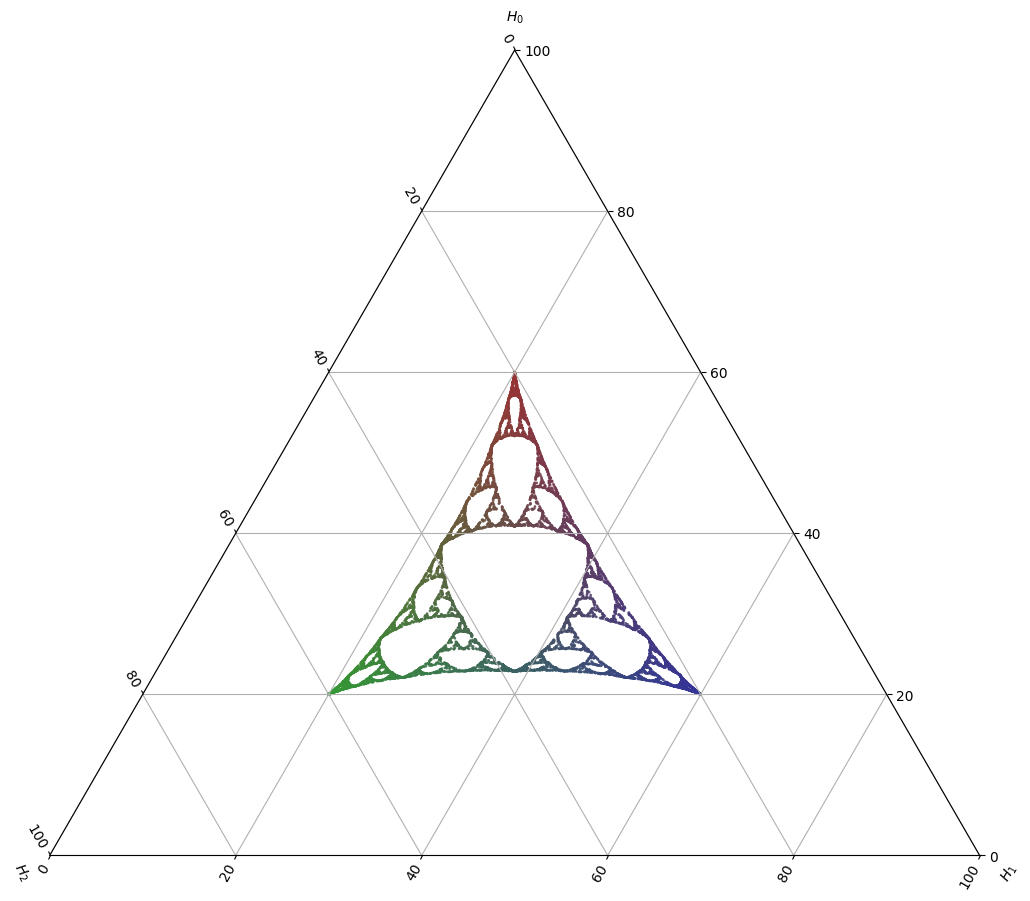

In [77]:
import matplotlib.pyplot as plt
import mpltern

def plot_distros(distros, labels = ['$H_0$', '$H_1$', '$H_2$'], dotsize = 1):
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(projection="ternary", ternary_sum=100.0, )

    ax.set_tlabel(labels[0])
    ax.set_rlabel(labels[1])
    ax.set_llabel(labels[2])
    ax.grid()

    t, l, r = zip(*distros)

    colors = [(t[i], l[i], r[i]) for i in range(len(t))]
    ax.scatter(t, l, r, alpha = 0.8, s = dotsize, c = colors)
    plt.show()

plot_distros(distros)

That's beautiful. Let's try another?

100%|██████████| 10000/10000 [00:00<00:00, 12932.05it/s]


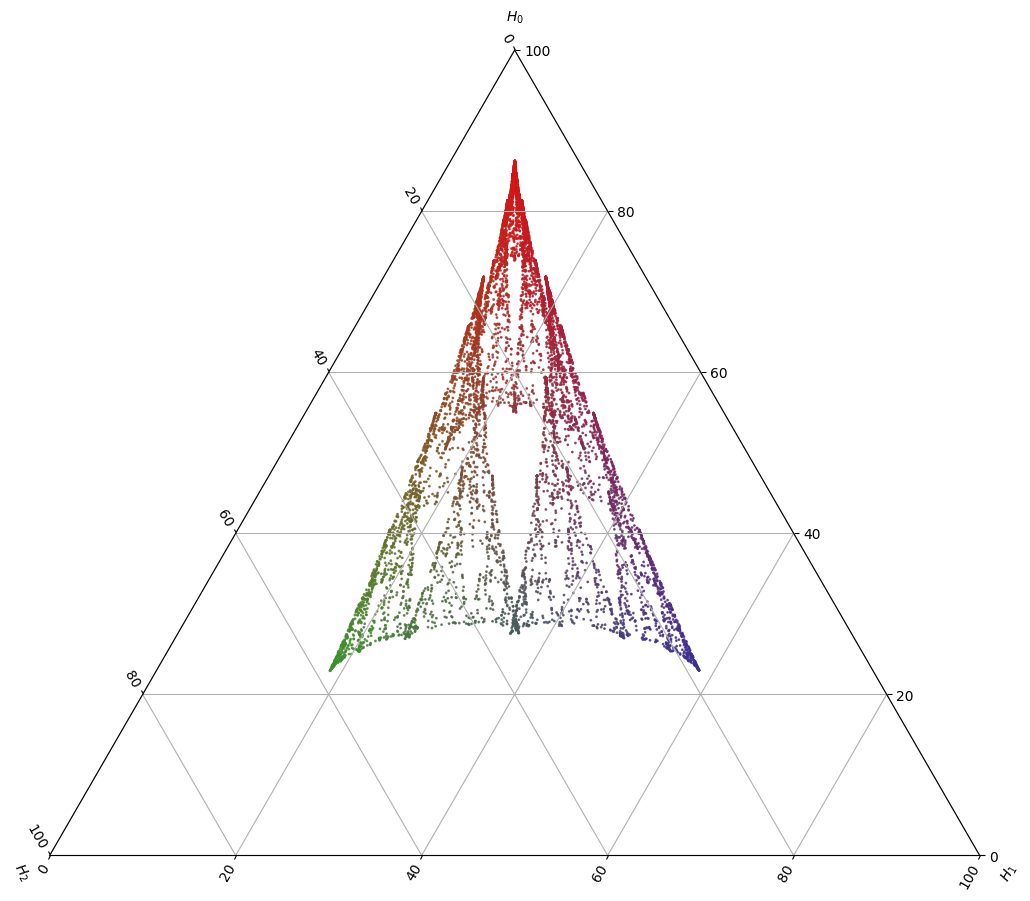

In [78]:
mess3_skewed = HiddenMarkovProcess(states = ['H0', 'H1', 'H2'],
                            transition_matrix = {'H0': [0.9, 0.05, 0.05], 
                                                 'H1': [0.15, 0.7, 0.15], 
                                                 'H2': [0.15, 0.15, 0.7]},
                            observation_matrix = {'H0': {'A': 0.6, 'B': 0.2, 'C': 0.2},
                                                  'H1': {'A': 0.2, 'B': 0.6, 'C': 0.2},
                                                  'H2': {'A': 0.2, 'B': 0.2, 'C': 0.6}})
distros = generate_distros(mess3_initial, mess3_skewed, 10000)
plot_distros(distros)

100%|██████████| 10000/10000 [00:00<00:00, 12618.35it/s]


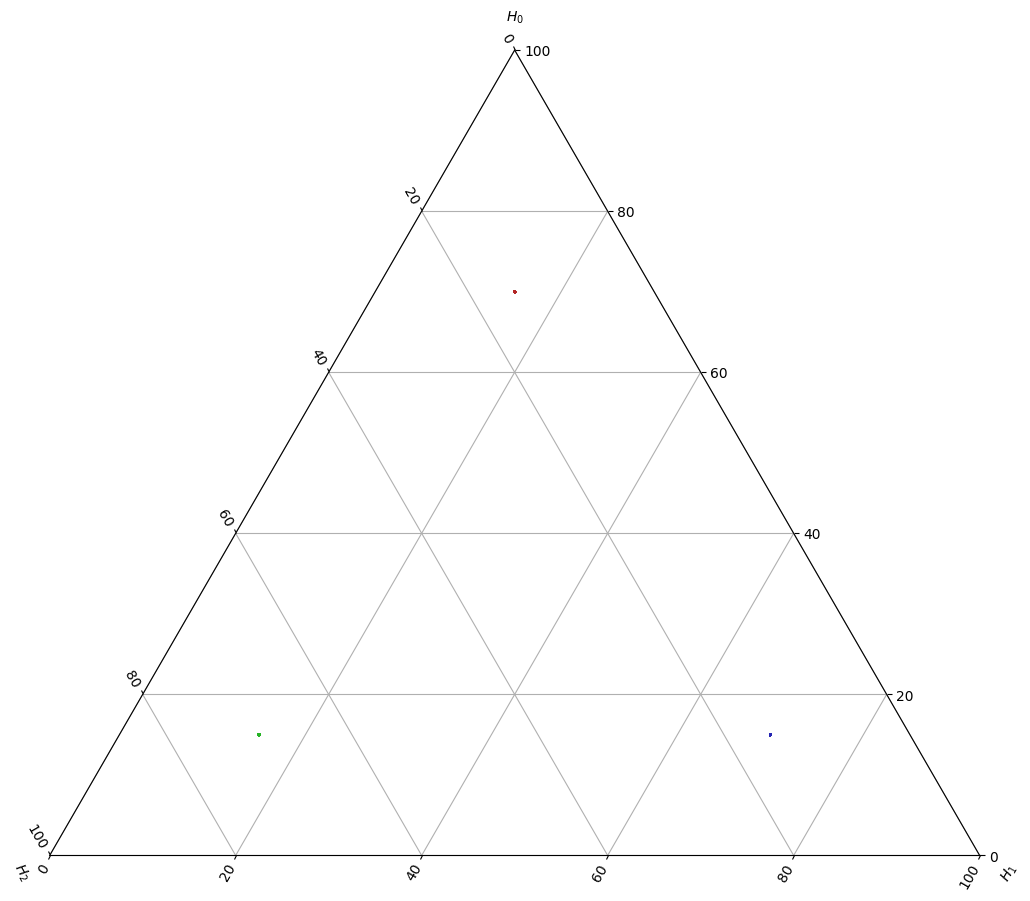

In [79]:
mess3_fullinfo = HiddenMarkovProcess(states = ['H0', 'H1', 'H2'],
                            transition_matrix = {'H0': [0.7, 0.15, 0.15], 
                                                 'H1': [0.15, 0.7, 0.15], 
                                                 'H2': [0.15, 0.15, 0.7]},
                            observation_matrix = {'H0': {'A': 1, 'B': 0, 'C': 0},
                                                  'H1': {'A': 0, 'B': 1, 'C': 0},
                                                  'H2': {'A': 0, 'B': 0, 'C': 1}})
distros = generate_distros(mess3_initial, mess3_fullinfo, 10000)
plot_distros(distros)

Let's do a visualization for the three-state Z1R process.

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 60417.24it/s]


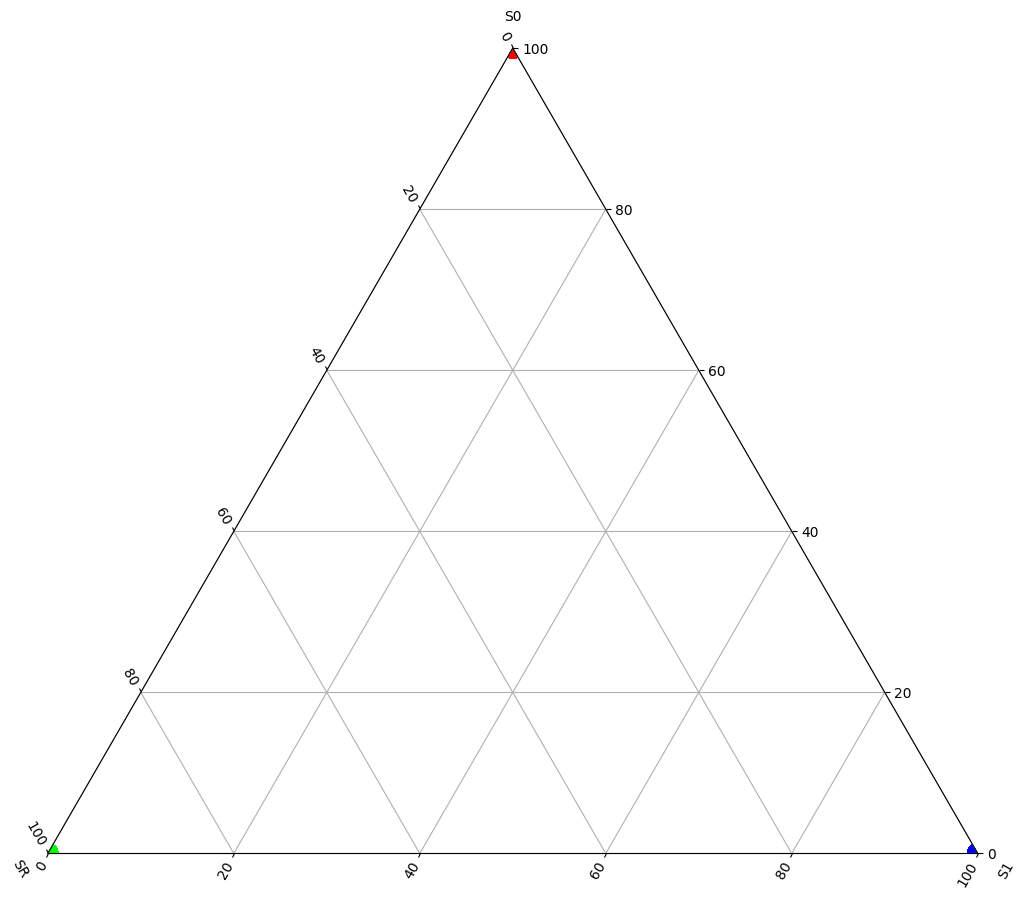

In [87]:
Z1R = HiddenMarkovProcess(states = ['S0', 'S1', 'SR'],
                            transition_matrix = {'S0': [0.0, 1, 0.0], # Add a little transition noise 
                                                 'S1': [0.0, 0.0, 1], 
                                                 'SR': [1, 0.0, 0]},
                            observation_matrix = {'S0': {'0': 1, '1': 0}, # Add a little observation noise
                                                  'S1': {'0': 0, '1': 1},
                                                  'SR': {'0': 0.5, '1': 0.5}})
Z1r_initial = DiscreteDistribution(states = ['S0', 'S1', 'SR'], probabilities = [1/3, 1/3, 1/3])
distros = generate_distros(Z1r_initial, Z1R, 10000, process_steps = 3) # Observation: it takes a minimum of 3 process_steps 
# for the MSP to have 100% confidence about the current state (points move into corners).
plot_distros(distros, labels = ['S0', 'S1', 'SR'], dotsize = 200)

100%|██████████| 10000/10000 [00:00<00:00, 12920.26it/s]


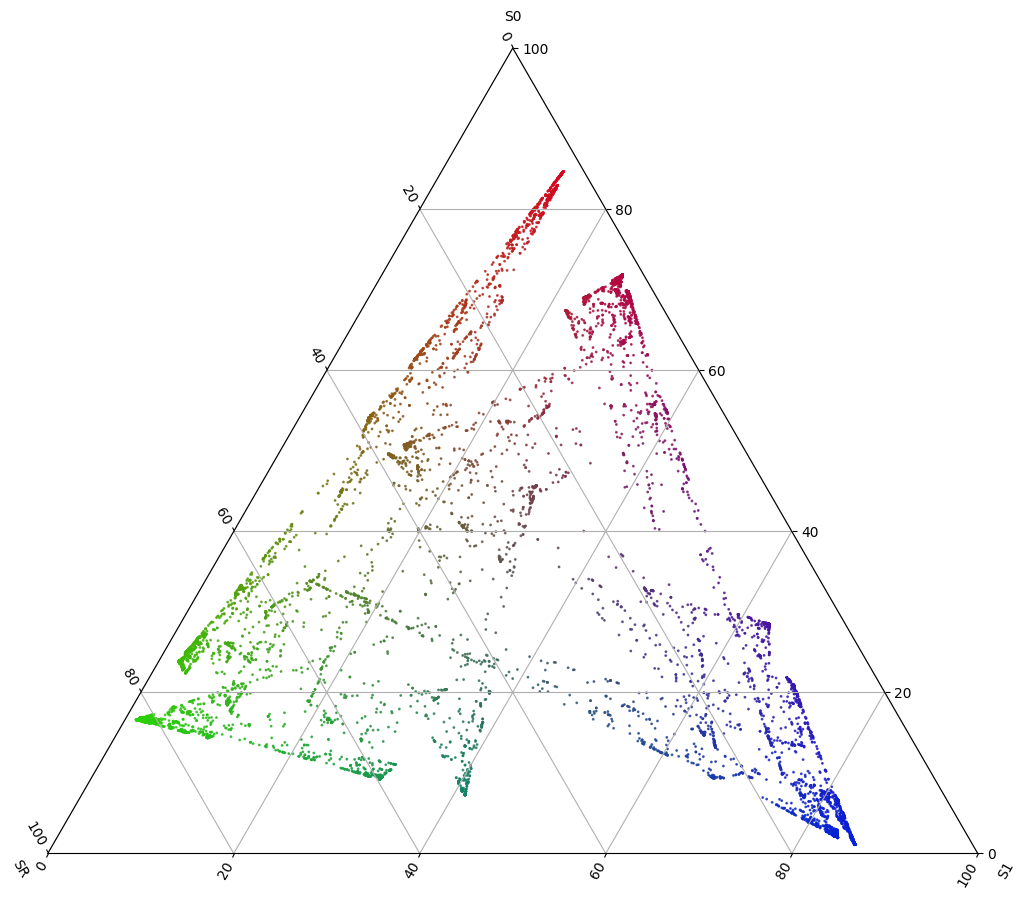

In [88]:
Z1R = HiddenMarkovProcess(states = ['S0', 'S1', 'SR'],
                            transition_matrix = {'S0': [0.1, 0.9, 0.0], # Add a little transition noise 
                                                 'S1': [0.0, 0.1, 0.9], 
                                                 'SR': [0.9, 0.0, 0.1]},
                            observation_matrix = {'S0': {'0': 0.85, '1': 0.15}, # Add a little observation noise
                                                  'S1': {'0': 0.15, '1': 0.85},
                                                  'SR': {'0': 0.5, '1': 0.5}})
Z1r_initial = DiscreteDistribution(states = ['S0', 'S1', 'SR'], probabilities = [1/3, 1/3, 1/3])
distros = generate_distros(Z1r_initial, Z1R, 10000)
plot_distros(distros, labels = ['S0', 'S1', 'SR'])